## Import Libraries

In [1]:
import pandas as pd 
import folium 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/us_energy_census_gdp_10-14/Energy Census and Economic Data US 2010-2014.csv
/kaggle/input/chipotle-locations/chipotle_stores.csv
/kaggle/input/chipotle-locations/us-states.json


In [2]:
#Read Data
df = pd.read_csv('/kaggle/input/chipotle-locations/chipotle_stores.csv')
df_gdp=pd.read_csv('/kaggle/input/us_energy_census_gdp_10-14/Energy Census and Economic Data US 2010-2014.csv')
df.head()

,state,location,address,latitude,longitude
0,Alabama,Auburn,"346 W Magnolia Ave Auburn, AL 36832 US",32.606813,-85.487328
1,Alabama,Birmingham,"300 20th St S Birmingham, AL 35233 US",33.509721,-86.802756
2,Alabama,Birmingham,"3220 Morrow Rd Birmingham, AL 35235 US",33.595581,-86.647437
3,Alabama,Birmingham,"4719 Highway 280 Birmingham, AL 35242 US",33.422582,-86.698279
4,Alabama,Cullman,"1821 Cherokee Ave SW Cullman, AL 35055 US",34.154134,-86.841220


## Mapping Chipotle outlets

In [3]:
usa_map = folium.Map([39.358, -98.118], zoom_start=4, tiles="Stamen toner")
for lat, lon,loc in zip(df.latitude, df.longitude,df.location):
    folium.CircleMarker([lat, lon],radius=10, color=None,
                        fill_color='red',fill_opacity=0.3,
                        tooltip="Location : "+str(loc)).add_to(usa_map)
usa_map

### Exploring the Chipotle data

In [4]:
total=len(df.state.unique())
print(f'Total Number of states with chipotle outlet : {total}')

Total Number of states with chipotle outlet : 48


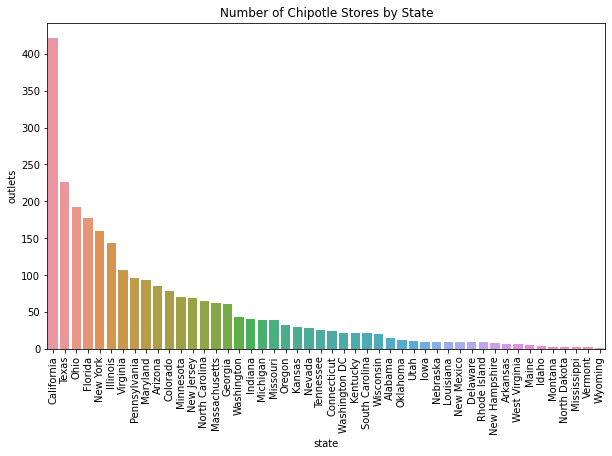

In [5]:
#Statewise distribution of Outlets
state_chip=df.state.value_counts()
df_state_chip=pd.DataFrame({'state':state_chip.index,
                           'outlets':state_chip.values})

plt.figure(figsize=(10,6))
plt.title("Number of Chipotle Stores by State")
sns.barplot('state', 'outlets', data=df_state_chip)
plt.xticks(rotation=90)
plt.show()

### Explore GDP and Census data

In [6]:
df_gdp.columns

Index(['StateCodes', 'State', 'Region', 'Division', 'Coast', 'Great Lakes',
       'TotalC2010', 'TotalC2011', 'TotalC2012', 'TotalC2013',
       ...
       'RINTERNATIONALMIG2013', 'RINTERNATIONALMIG2014', 'RDOMESTICMIG2011',
       'RDOMESTICMIG2012', 'RDOMESTICMIG2013', 'RDOMESTICMIG2014',
       'RNETMIG2011', 'RNETMIG2012', 'RNETMIG2013', 'RNETMIG2014'],
      dtype='object', length=192)

In [7]:
#Selecting only the required columns
df_gdp=df_gdp[['State', 'GDP2014', 'POPESTIMATE2014']]
df_gdp.head()

,State,GDP2014,POPESTIMATE2014
0,Alabama,197534.50,4849377
1,Alaska,58066.75,736732
2,Arizona,281558.75,2966369
3,Arkansas,121064.75,6731484
4,California,2324995.50,38802500


In [8]:
#States in GDP data only
set(df_gdp.State)-set(df_state_chip.state)

{'Alaska', 'District of Columbia', 'Hawaii', 'South Dakota', 'United States'}

In [9]:
#States in Chipotle data only
set(df_state_chip.state)-set(df_gdp.State)

{'Washington DC'}

* We will only consider the states in Mainland US 

In [10]:
#Removing states not required and renaming the columns
df_gdp=df_gdp[df_gdp.State.isin(['Alaska', 'Hawaii', 'United States'])==False]
df_gdp.State[df_gdp.State=='District of Columbia']='Washington DC'
df_gdp=df_gdp.rename(columns={'State':'state','GDP2014':'gdp','POPESTIMATE2014':'popl'})
df_gdp.head()

,state,gdp,popl
0,Alabama,197534.50,4849377
2,Arizona,281558.75,2966369
3,Arkansas,121064.75,6731484
4,California,2324995.50,38802500
5,Colorado,305366.75,5355866


In [11]:
#Adding South Dakota to State list for Chipotle Stores
df_state_chip=df_state_chip.append(pd.Series({'state':'South Dakota','outlets':0}),ignore_index=True)

In [12]:
# Joining the stores and stats dataframes
df_merged=pd.merge(df_state_chip,df_gdp, on='state')
df_merged.head()

,state,outlets,gdp,popl
0,California,421,2324995.50,38802500
1,Texas,226,1601976.75,26956958
2,Ohio,193,588827.75,11594163
3,Florida,177,835578.50,19893297
4,New York,160,1385776.25,19746227


In [13]:
#Calculating GDP per capita
df_merged["gdp_pc"]=round(df_merged.gdp/df_merged.popl,2)
df_merged.head()

,state,outlets,gdp,popl,gdp_pc
0,California,421,2324995.50,38802500,0.06
1,Texas,226,1601976.75,26956958,0.06
2,Ohio,193,588827.75,11594163,0.05
3,Florida,177,835578.50,19893297,0.04
4,New York,160,1385776.25,19746227,0.07


### Correlation Heatmap

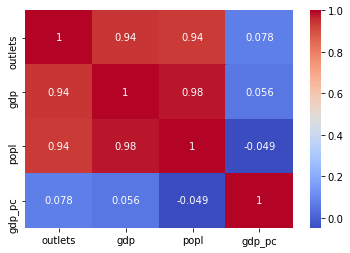

In [14]:
sns.heatmap(df_merged.corr(), annot=True, cmap='coolwarm')
plt.show()

OBSERVATIONS:
* Number of outlets is highly correlated with state GDP and Population
* GDP per capita does not affect number of outlets

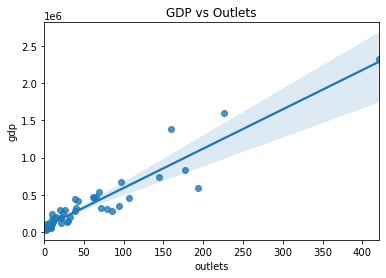

In [15]:
plt.title("GDP vs Outlets")
sns.regplot('outlets','gdp', data=df_merged)
plt.show()

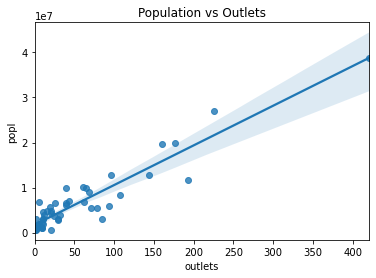

In [16]:
plt.title("Population vs Outlets")
sns.regplot('outlets','popl', data=df_merged)
plt.show()

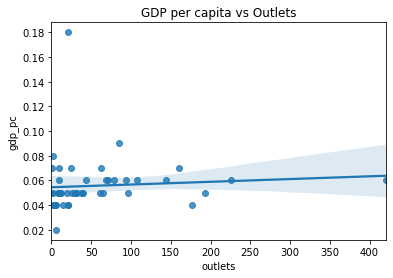

In [17]:
plt.title("GDP per capita vs Outlets")
sns.regplot('outlets','gdp_pc', data=df_merged)
plt.show()

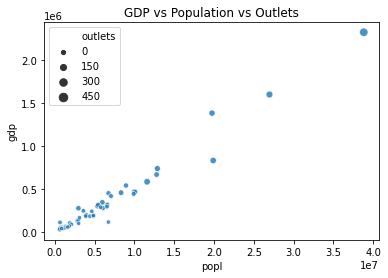

In [18]:
plt.title("GDP vs Population vs Outlets")
sns.scatterplot('popl','gdp',size='outlets', alpha=0.8, data=df_merged)
plt.show()

OBSERVATIONS:
* Number of outlets is highly correlated with GDP and Population
* Number of outlets is not correlated with GDP per capita
* California is an outlier in the case of GDP and Population which is affecting the correlation. 
* GDP is highly correlated with population (multicollinearity to be explored)

# Predicting the Number of Outlets based on GDP and Population

In [19]:
#Select Features and target
X=df_merged[['gdp','popl']]
y=df_merged.outlets

In [20]:
#Fitting Linear Regression
model=LinearRegression()
model.fit(X,y)
print(f"R2 score : {round(model.score(X,y)*100,2)}%")

R2 score : 89.23%


In [21]:
#Predicting the number of Outlets
y_pred=model.predict(X)
y_pred=np.round(y_pred,0)
y_pred

array([386., 264.,  98., 153., 216., 120.,  73., 111.,  52.,  35.,  45.,
        47.,  84.,  79.,  67.,  80.,  64.,  51.,  76.,  45.,  29.,  19.,
        17.,  48.,  33.,   8.,  29.,  30.,  45.,  31.,  27.,  18.,  22.,
        11.,  36.,  10.,   3.,   2.,   5.,  28.,   7.,   3.,   5.,   1.,
         2.,  14.,  -2.,  -1.,   1.])

In [22]:
#Adding Predicted Outlets to main dataframe
df_merged['outlets_pred']=y_pred
df_merged.outlets_pred=df_merged.outlets_pred.astype('int')
df_merged.head()

,state,outlets,gdp,popl,gdp_pc,outlets_pred
0,California,421,2324995.50,38802500,0.06,386
1,Texas,226,1601976.75,26956958,0.06,264
2,Ohio,193,588827.75,11594163,0.05,98
3,Florida,177,835578.50,19893297,0.04,153
4,New York,160,1385776.25,19746227,0.07,216


### Underserved and overserved markets

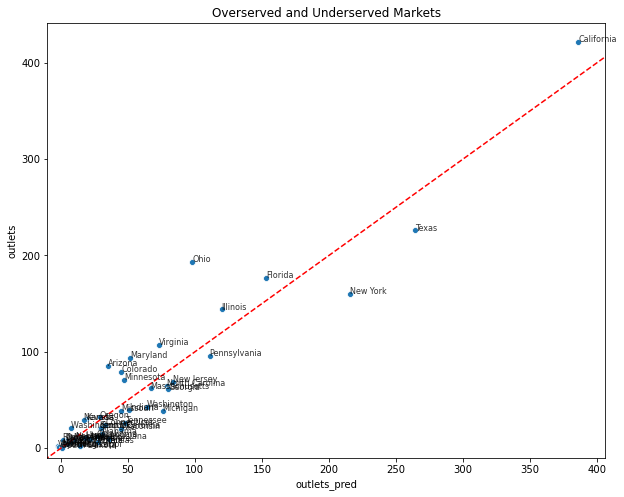

In [23]:
plt.figure(figsize=(10,8))
plt.title("Overserved and Underserved Markets")
plot=sns.scatterplot('outlets_pred','outlets',data=df_merged)
for i in range(0, df_merged.shape[0]):
    plot.text(df_merged.outlets_pred[i], df_merged.outlets[i], df_merged.state[i], alpha=0.8, fontsize=8 )
plt.plot([-50,500],[-50,500],'r--')
plt.xlim(-10,max(df_merged.outlets_pred)+20)
plt.ylim(-10,max(df_merged.outlets)+20)
plt.show()

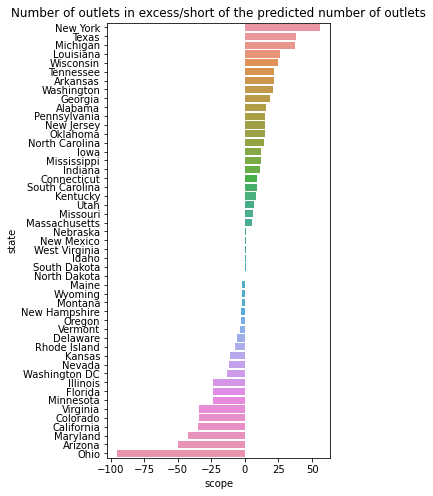

In [24]:
#Calculating the number of outlets in excess/short of the predicted number of outlets
df_merged['scope']=df_merged.outlets_pred-df_merged.outlets
plt.figure(figsize=(4,8))
plt.title("Number of outlets in excess/short of the predicted number of outlets")
sns.barplot(data=df_merged.sort_values(by='scope', ascending=False),
           x='scope',y='state', orient='h')
plt.show()
#df_merged.sort_values(by='scope', ascending=False)

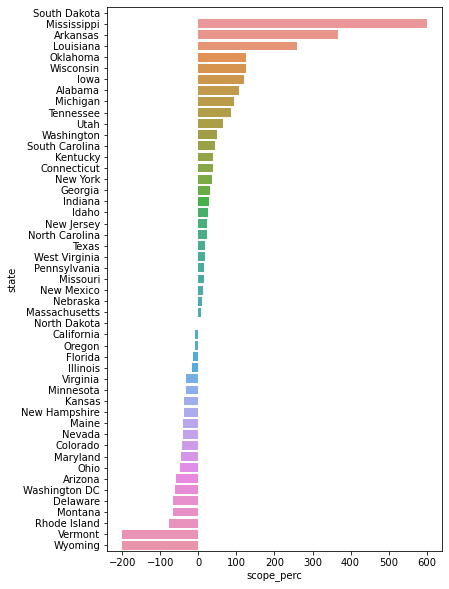

In [25]:
# Percentage increase of decrease in number of stores per state
df_merged['scope_perc']=round(df_merged.scope*100/df_merged.outlets,2)
df_merged.sort_values(by='scope_perc', ascending=False, inplace=True)

plt.figure(figsize=(6,10))
sns.barplot(y=df_merged.state, x=df_merged.scope_perc, orient='h')
plt.show()
#df_merged

### OBSERVATION
* According to the model, Vermont and Wyoming should not have any outlets of Chipotle
* South Dakota which currently does not have any stores now, should ideally have one store
* There are many states with very small number of outlets, which is greatly impacting the scope percentage.

In [26]:
# Taking only states where more than 5 stores should be opened or closed and scope perc greater than +/-20%

In [27]:
df_final=df_merged[(abs(df_merged.scope_perc)>50)& (abs(df_merged.scope)>4)].reset_index()
df_final.head(10)

,index,state,outlets,gdp,popl,gdp_pc,outlets_pred,scope,scope_perc
0,45,Mississippi,2,104937.50,2994079,0.04,14,12,600.00
1,39,Arkansas,6,121064.75,6731484,0.02,28,22,366.67
2,34,Louisiana,10,245790.75,4649676,0.05,36,26,260.00
3,30,Oklahoma,12,190170.50,3878051,0.05,27,15,125.00
4,28,Wisconsin,20,293341.25,5757564,0.05,45,25,125.00
5,32,Iowa,10,170715.00,3107126,0.05,22,12,120.00
6,29,Alabama,15,197534.50,4849377,0.04,31,16,106.67
7,18,Michigan,39,447221.25,9909877,0.05,76,37,94.87
8,23,Tennessee,26,300015.25,6549352,0.05,48,22,84.62
9,31,Utah,11,140565.00,2942902,0.05,18,7,63.64


In [28]:
df_final.tail(10)

,index,state,outlets,gdp,popl,gdp_pc,outlets_pred,scope,scope_perc
4,28,Wisconsin,20,293341.25,5757564,0.05,45,25,125.00
5,32,Iowa,10,170715.00,3107126,0.05,22,12,120.00
6,29,Alabama,15,197534.50,4849377,0.04,31,16,106.67
7,18,Michigan,39,447221.25,9909877,0.05,76,37,94.87
8,23,Tennessee,26,300015.25,6549352,0.05,48,22,84.62
9,31,Utah,11,140565.00,2942902,0.05,18,7,63.64
10,9,Arizona,85,281558.75,2966369,0.09,35,-50,-58.82
11,25,Washington DC,21,116539.25,658893,0.18,8,-13,-61.90
12,36,Delaware,9,65484.75,935614,0.07,3,-6,-66.67
13,37,Rhode Island,9,55098.25,1055173,0.05,2,-7,-77.78


In [29]:
df_final['perc_change']=abs(df_final.scope_perc)
df_final['density']=df_final.scope.apply(lambda x: "Underserved" if x>0 else "Overserved")
df_final

,index,state,outlets,gdp,popl,gdp_pc,outlets_pred,scope,scope_perc,perc_change,density
0,45,Mississippi,2,104937.50,2994079,0.04,14,12,600.00,600.00,Underserved
1,39,Arkansas,6,121064.75,6731484,0.02,28,22,366.67,366.67,Underserved
2,34,Louisiana,10,245790.75,4649676,0.05,36,26,260.00,260.00,Underserved
3,30,Oklahoma,12,190170.50,3878051,0.05,27,15,125.00,125.00,Underserved
4,28,Wisconsin,20,293341.25,5757564,0.05,45,25,125.00,125.00,Underserved
5,32,Iowa,10,170715.00,3107126,0.05,22,12,120.00,120.00,Underserved
6,29,Alabama,15,197534.50,4849377,0.04,31,16,106.67,106.67,Underserved
7,18,Michigan,39,447221.25,9909877,0.05,76,37,94.87,94.87,Underserved
8,23,Tennessee,26,300015.25,6549352,0.05,48,22,84.62,84.62,Underserved
9,31,Utah,11,140565.00,2942902,0.05,18,7,63.64,63.64,Underserved


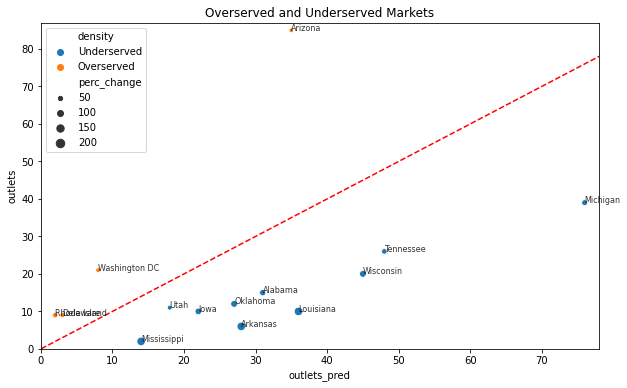

In [30]:
plt.figure(figsize=(10,6))
plt.title("Overserved and Underserved Markets")
plot=sns.scatterplot('outlets_pred','outlets',data=df_final,
                     size='perc_change', size_norm=(50,200),
                     hue='density')
for i in range(0, df_final.shape[0]):
    plot.text(df_final.outlets_pred[i], df_final.outlets[i], df_final.state[i], alpha=0.8, fontsize=8 )
plt.plot([-50,500],[-50,500],'r--')
plt.xlim(0,max(df_final.outlets_pred)+2)
plt.ylim(0,max(df_final.outlets)+2)
plt.show()

## RECOMMENDATION
* Chipotle should increase the stores in the underserver states, especially Mississippi, Arkansas, Louisiana, Oklahoma,	Wisconsin, Iowa and Alabama.
* Arizona, Washington DC, Delaware and Rhode Island states are overserved hence outlets have to be streamlined in these areas

### CAUTION
* This analysis is highly simplified, 2014 population and gdp are used for estimaion of number of outlets. However the number of outlets depends on many other factors which are not considered in this analysis. 
* Impact of outliers is not factored in the regression, which could highly skew the predictions.

# Please upvote if you liked the notebook.